# Clustering visualizer using predefined roles and features configuration

## Importing libraries

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

## Importing the datasets

In [72]:
data_path = "../datasets/"

clear_scaled_data_path = data_path + "clear_scaled_data.csv"
clear_data_path = data_path + "clear_data.csv"
data_with_nan_path = data_path + "data_with_nan.csv"
scaled_data_with_nan_path = data_path + "scaled_data_with_nan.csv"

clear_scaled_data = pd.read_csv(clear_scaled_data_path)
clear_data = pd.read_csv(clear_data_path)
data_with_nan = pd.read_csv(data_with_nan_path)
scaled_data_with_nan = pd.read_csv(scaled_data_with_nan_path)

## Define role and feature configuration

In [73]:
# conditions for each role have this format:
# "feature_name": [min_value, max_value]
# If min_value is None, there is no lower bound.
# If max_value is None, there is no upper bound.
role_config = [
    {
        "name": "Power User",
        "conditions": {
            "PostsAmount": [0.7, None],
            "VotePositive": [0.7, None]
        }
    },
    {
        "name": "Opinion Leader",
        "conditions": {
            "ReceivedPositive": [0.8, None]
        }
    },
    {
        "name": "Polarizer",
        "conditions": {
            "ReceivedPositive": [0.7, None],
            "ReceivedNegative": [0.7, None]
        }
    },
    {
        "name": "Silent Voter",
        "conditions": {
            "PostsAmount": [None, 0.3],
            "VotePositive": [0.7, None]
        }
    },
    {
        "name": "Lurker",
        "conditions": {
            "PostsAmount": [None, 0.3],
            "VotePositive": [None, 0.3],
            "clicks_in_last_90_articles": [None, 0.3]
        }
    },
    {
        "name": "Connector",
        "conditions": {
            "ActivityCentrality": [0.7, None],
            "GotFollowers": [0.6, None],
            "PostReplied": [0.5, None]
        }
    },
    {
        "name": "Amplifier",
        "conditions": {
            "VotePositive": [0.6, None],
            "ReceivedPositive": [0.7, None],
            "UserFollowed": [0.7, None]
        }
    },
    {
        "name": "Specialist",
        "conditions": {
            "PostsAmount": [0.8, None],
            "TopicsPostedIn": [None, 0.4],
            "ReceivedPositive": [0.7, None]
        }
    },
    {
        "name": "Controversialist",
        "conditions": {
            "PostsAmount": [0.5, None],
            "ReceivedPositive": [0.6, None],
            "ReceivedNegative": [0.6, None]
        }
    },
    {
        "name": "Explorer",
        "conditions": {
            "PostsAmount": [None, 0.4],
            "TopicsPostedIn": [0.6, None],
            "clicks_in_last_90_articles": [0.7, None]
        }
    }
]

In [74]:
def evaluate_conditions(row, conditions):
    for feature, (min_val, max_val) in conditions.items():
        if min_val is not None and row[feature] < min_val:
            return False
        if max_val is not None and row[feature] > max_val:
            return False
    return True

def assign_role(row, role_config):
    for role in role_config:
        if evaluate_conditions(row, role["conditions"]):
            return role["name"]
    return "Uncategorized"

def assign_roles(data, role_config):
    data['Role'] = data.apply(assign_role, axis=1, args=(role_config,))
    return data

def perform_clustering(data, distance_threshold):
    linked = linkage(data.iloc[:, 1:-1], method='ward')  # remove userId and role cols
    cluster_labels = fcluster(linked, t=distance_threshold, criterion='distance')
    data['Cluster'] = cluster_labels
    return data

def assign_roles_and_cluster(data, role_config, distance_threshold = 5):
    data = assign_roles(data, role_config)
    data = perform_clustering(data, distance_threshold)
    return data

## Plotting the roles in 2D

In [75]:
def visualize_roles_2D(data):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data.iloc[:, 1:-2])  # Exclude userId, role and cluster cols
    data['PCA1'] = reduced_data[:, 0]
    data['PCA2'] = reduced_data[:, 1]

    plt.figure(figsize=(10, 7))
    for role in data['Role'].unique():
        role_data = data[data['Role'] == role]
        plt.scatter(role_data['PCA1'], role_data['PCA2'], label=f'Role {role}', alpha=0.7)
    plt.title('Roles in 2D PCA space ')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()

## Plotting the data in 3D

In [76]:
def visualize_roles_3D(data):
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    pca_3d = PCA(n_components=3)
    reduced_data_3d = pca_3d.fit_transform(data[numeric_columns])  # only numeric cols

    data['PCA1'] = reduced_data_3d[:, 0]
    data['PCA2'] = reduced_data_3d[:, 1]
    data['PCA3'] = reduced_data_3d[:, 2]

    fig = plt.figure(figsize=(18, 12))
    ax = fig.add_subplot(111, projection='3d')
    for role in data['Role'].unique():
        role_data = data[data['Role'] == role]
        ax.scatter(role_data['PCA1'], role_data['PCA2'], role_data['PCA3'], label=f'Role {role}', alpha=0.7)
    ax.set_title('Roles in 3D PCA space')
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.legend()
    ax.set_box_aspect([1, 1, 1])
    plt.show()


## Using the processing/visualization pipeline

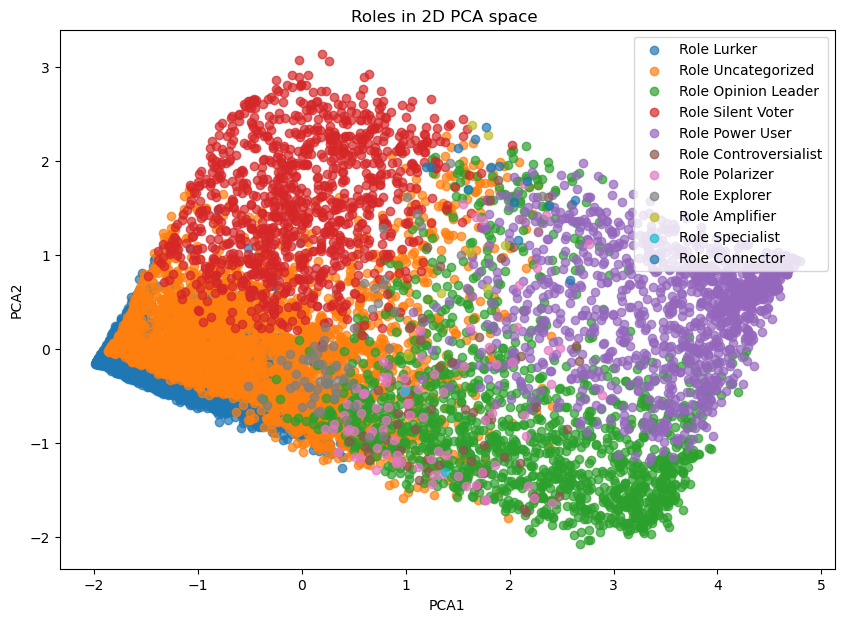

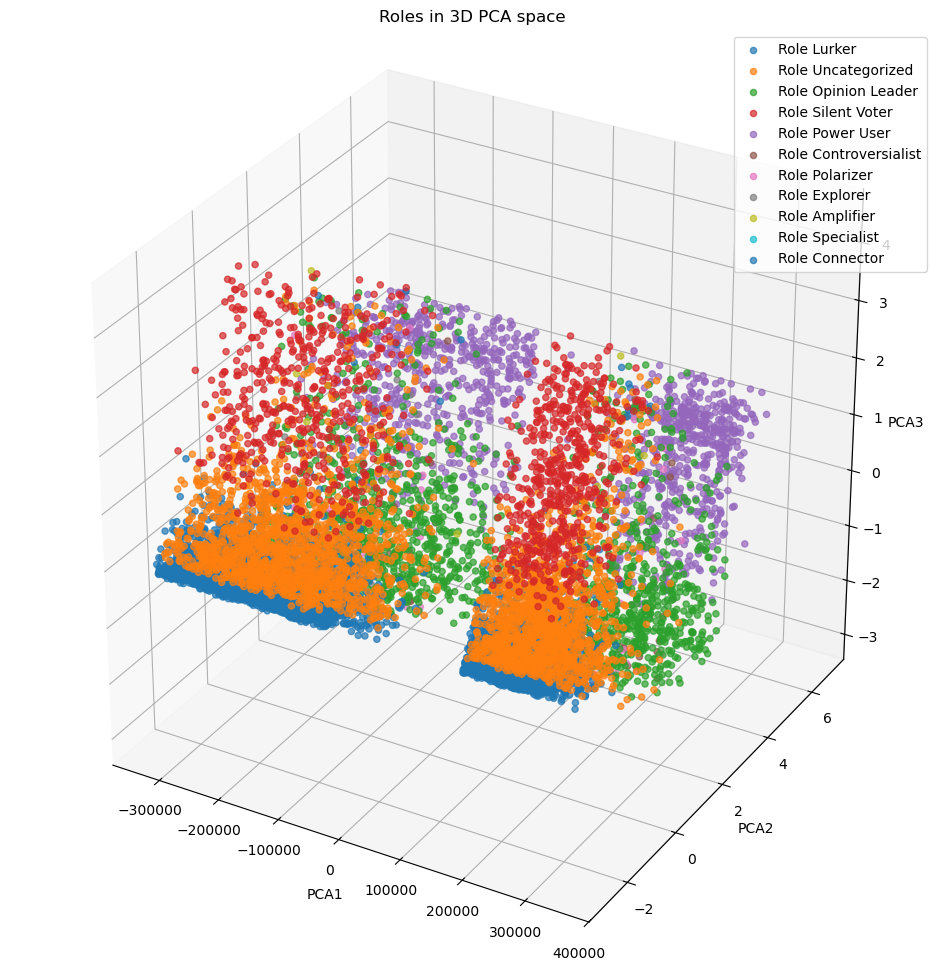

In [77]:
data = assign_roles_and_cluster(clear_scaled_data, role_config, distance_threshold=5)
visualize_roles_2D(data)
visualize_roles_3D(data)